In [1]:
install.packages("openxlsx")
install.packages('gridExtra')
install.packages("glmnet")
if(!require('pacman')) {
  install.packages('pacman')
}
pacman::p_load(tidyverse, skimr, RCurl, 
               data.table,bit64,stringr,readxl,tidyr,haven,purrr,
               splitstackshape,bestglm, glmnet, leaps, car,
              rattle, pROC, usmap, xtable, ggcorrplot, 
              fastDummies, caret, janitor, here) 

# Preliminary setup
install.packages('versions')
library(versions)
# Install package CmdStanR from GitHub
library(devtools)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘Rcpp’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘iterators’, ‘foreach’, ‘shape’, ‘RcppEigen’


Loading required package: pacman

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘pacman’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


skimr installed

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘bitops’



RCurl installed

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


splitstackshape installed

Installing package

# Conducting Variable Selection Using Lasso

In [2]:
final_data <- read.csv(
  "../data/post_final_cleaned_up_final_model_data.csv")

In [3]:
# Here I selected a subset of variables in order to expedite
# the model selection and variable selection. In reality this would
# not be considered to be good practice.

final_data <- final_data %>% select(
    'race_code','birth_age',
    'totalvotes','trump_voteshare2016','med_home_value',
    'pct_bachelors_degree','pct_below_poverty',
    'pct_black','pct_foreign_born',
    'pct_hispanic','pct_white',
    'donation_total','donation_through_2019',
    'donation_2012_through_2015',
    'donation_2016_through_2019',
    'gender','political_party','donation_2016_binary',
    'donation_2020_binary','new_donor','county'
)

In [4]:
#make this example reproducible
set.seed(1989)

create_train_test <- function(data, size = 0.7, train = TRUE) {
    n_row = nrow(data)
    total_row = size * n_row
    train_sample <- 1: total_row
    if (train == TRUE) {
        return (data[train_sample,])
    } else {
        return (data[-train_sample,])
    }
}
data_train <- create_train_test(final_data, 0.7, train = TRUE)
data_test <- create_train_test(final_data, 0.7, train = FALSE)
dim(data_train)
dim(data_test)

[1] 48891    21

[1] 20954    21

In [5]:
# Remove 1 individual in test who have multiple NAs in variables used in modeling
train <- data_train %>% drop_na()
test <- data_test %>% drop_na()
dim(train)
dim(test)

[1] 48891    21

[1] 20953    21

In [6]:
y_train <- as.matrix(train[,"donation_2020_binary"])
X_train <- model.matrix(donation_2020_binary~., data = train)[,-1]

dim(y_train)
dim(X_train)

[1] 48891     1

[1] 48891   121

In [7]:
lasso_fit_one <- cv.glmnet(X_train, y_train, alpha=0.1, 
  family="binomial", type.measure="deviance")

The above plot shows the performance of the LASSO logistic regression model as measured by deviance across various values for lambda (i.e., the penalization hyperparameter). The plot shows that adding additional covariates gradually reduces the deviance. 

Notice that up to approximately log(lambda) = -5, reduction in deviances ceases - despite adding significantly more variables. 

As a result, in the second model I will manually set the lambda term to equal 0.0067 (i.e., exponential(-5)).

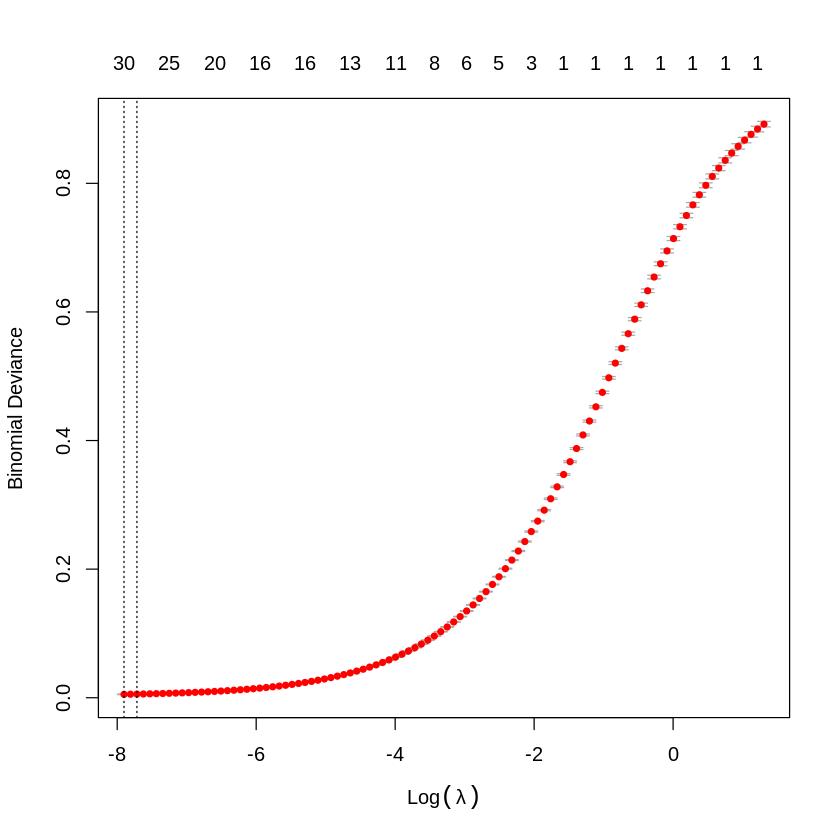

In [8]:
plot(lasso_fit_one)

In [9]:
coef <- coef(lasso_fit_one, s=exp(-5))
# Variables selected from LASSO procedure
var_min <- coef@Dimnames[[1]][coef@i + 1][-1]

In [10]:
# create dummy indicators for significant factor levels identified by LASSO
create_indicator_vars <- function(data){

  # Gender
  dummies_for_gender <- fastDummies::dummy_cols(data$gender)
  dummies_for_gender <- dummies_for_gender %>% 
    clean_names() %>% 
    select(data_m, data_u) %>% 
    rename(
            gender_male = data_m,
           gender_undeclared = data_u
    )
  
  # County
  dummies_for_county <- fastDummies::dummy_cols(data$county)
  dummies_for_county <- dummies_for_county %>% 
    clean_names() %>% 
    select(
      'data_beaufort_county',
     'data_wilkes_county'
    ) %>% 
    rename(
      county_beaufort = 'data_beaufort_county',
      county_wilkes ='data_wilkes_county'
    )
  
  # combine columns together
  dummy_vector <- cbind(dummies_for_gender, dummies_for_county)
  return(dummy_vector)
}

In [11]:
# Indicator variable data for training set
create_indicator_vars_train <- create_indicator_vars(train)

combined_train <- data.frame(cbind(train, create_indicator_vars_train))

# Indicator variable data for testing set
create_indicator_vars_test <- create_indicator_vars(test)
combined_test <- data.frame(cbind(test, create_indicator_vars_test))


dim(combined_train)
dim(combined_test)

[1] 48891    25

[1] 20953    25

In [12]:
# Final model using LASSO - this is going to be potentially singular matrix
# In order to handle this I remove the counties and gender as
# we hypothetically asssume the election board does not want to include 
# gender and the counties for public reporting. I have run into this issue before
# in the instances where the public organization does not want to receive critical PR
# This also gives me a chance to analyze a subset of variables and talk through 
# my thought process.
lasso_fit_two <-
  glm(
    donation_2020_binary ~  birth_age + trump_voteshare2016 + county_beaufort + race_code,
    family = binomial, na.action=na.exclude, data=combined_train
  )

# Create plot for logistic regression results
summary_lasso <- as.data.frame(summary(lasso_fit_two)[["coefficients"]])
summary_lasso <- summary_lasso %>% 
  rownames_to_column("Covariate") %>% 
  filter(Covariate != "(Intercept)")
colnames(summary_lasso) <- c("Covariate","Estimate","Standard_Error","Z","P")
summary_lasso$Estimate <- as.numeric(summary_lasso$Estimate)
summary_lasso$SE <- as.numeric(summary_lasso$Standard_Error)
summary_lasso

Covariate,Estimate,Standard_Error,Z,P,SE
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
birth_age,-0.013746458,0.0008188342,-16.78783975,2.995514e-63,0.0008188342
trump_voteshare2016,0.916968945,0.0774049810,11.84638164,2.246845e-32,0.0774049810
county_beaufort,0.899922036,0.0939863029,9.57503389,1.018239e-21,0.0939863029
race_codeB,-0.358904343,0.1560059504,-2.30058111,2.141532e-02,0.1560059504
race_codeI,-0.534583536,0.3184041602,-1.67894646,9.316248e-02,0.3184041602
race_codeM,-0.291068023,0.2767223504,-1.05184139,2.928723e-01,0.2767223504
race_codeO,-0.332884301,0.1959252368,-1.69903738,8.931214e-02,0.1959252368
race_codeP,1.062412068,1.4319926586,0.74191167,4.581409e-01,1.4319926586
race_codeU,0.002289695,0.1616086345,0.01416815,9.886958e-01,0.1616086345


Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


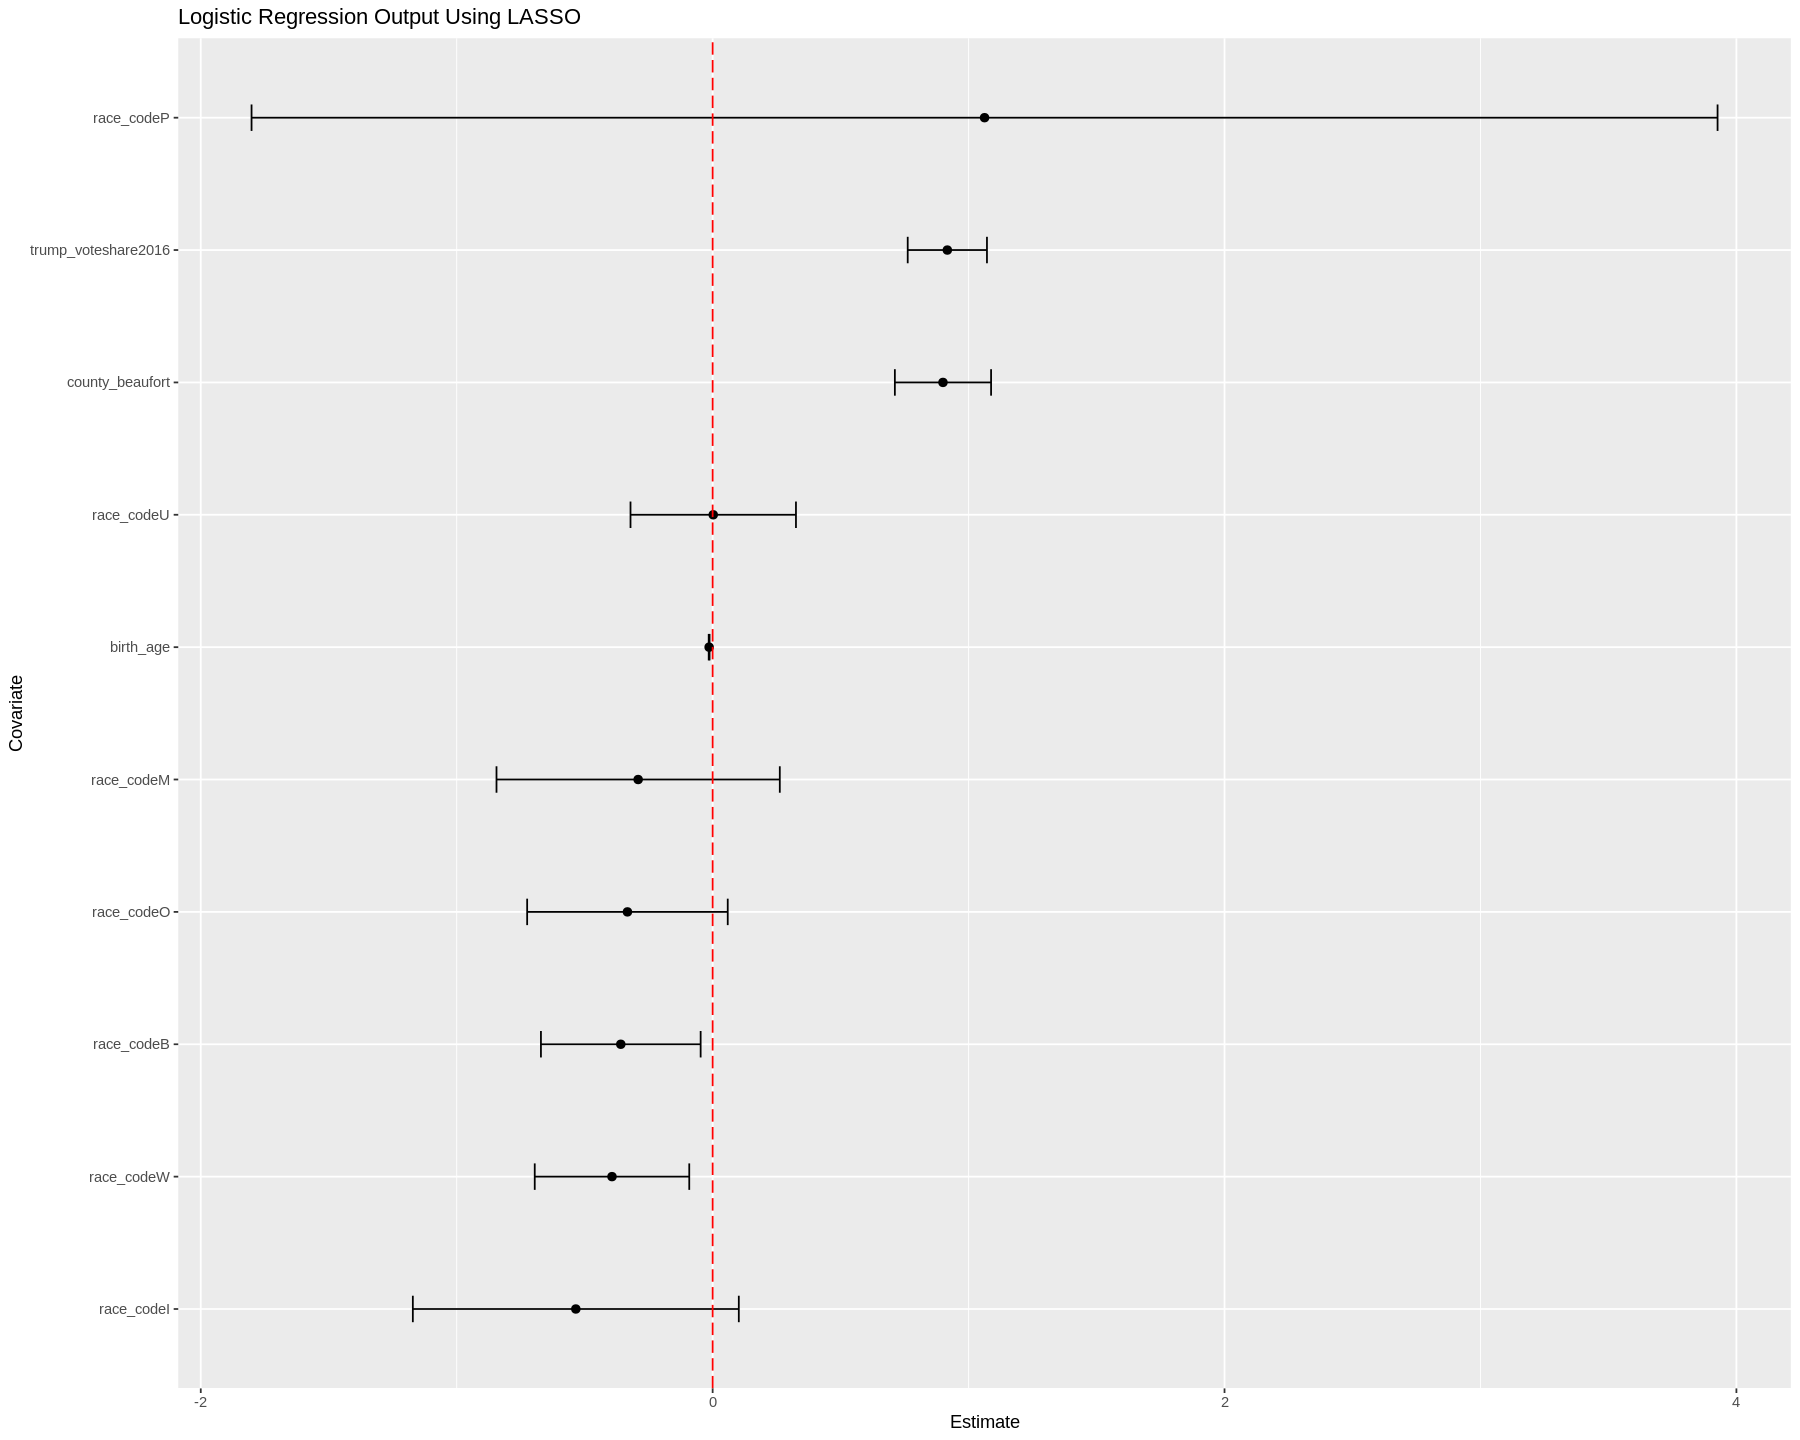

In [13]:
options(repr.plot.width=15, repr.plot.height=12)

ggplot(summary_lasso, aes(x = forcats::fct_reorder(as.factor(Covariate),Estimate), y = Estimate)) +
geom_point(size = 2) +
geom_errorbar(width=.2,size=0.5,aes(ymin = Estimate - (2*SE), ymax = Estimate + (2*SE))) +
geom_hline(yintercept = 0,
           linetype = "longdash",
           color = "red") +
  coord_flip() +
  labs(y = "Estimate",
       x = "Covariate",
       title = "Logistic Regression Output Using LASSO")

The above summary and plot shows the logit model's coefficients and their confidence intervals using the LASSO. 


Amongst others, a few quick takeaways from the above figure: 

1. Voters living in counties with a higher voting share for Donald Trump in the 2016 election were more likely to donate in 2020.

2. Voters that self-idenitified as "Pacific Islander" were more likely to donate in 2020. However the the standard erors are very large - indicating there is possible multicollinearity between covariates. Collinearity imposes restraints of equivalency of parameter estimates, thus degeneracy. Coefficients for highly collinear variables are ill defined and cancel each other numerically, thus fitting them is another form of infinite estimation.

3. Residents of Beaufort county were more likely to contribute in 2020.

4. All other individuals who self-identified with another racial group were less likely to donate in 2020. 

**If I had more time dedicated to this toy example here is my thought process on possible next steps**:

1) Check for collinearity; try fitting the interaction between suspect variables with inflated SE, with and without main effects - which should result in small interaction SE and little change in model fit; 

2) fit the model to Gaussian distribution, with will shrink SE to 0 if the problem is identifiability; 


3) as a brute force check on sample size, rerun the model on a duplicate of the dataset appended to itself which will substantially reduce the SE if sample size is a problem but parameters will be identical.

What sample size "ought" to be is relative, dependent on ones needs, data, and question, all of which determine ones model and inferences. What do we consider "high", and why is it a problem? What is a reasonable expectation for the probabilities you are estimating?


Mathematically, the only requirement is that you have sufficient observations to estimate the population probabilities. For two treatments without an effect (p=0.5 for both), you only need 6 observations. If p = 0.1 for a treatment, then you need at least 10 observations for that treatment; for p = 0.01, n > 100, etc. This all assumes that in each treatment, Y contains both 0's and 1's. So what is reasonable for this kind of problem domain?

As for "high standard errors", model SE is the reliability of parameter estimates based upon the data, not a measure of the reliability of your data per se. The question is if the interpretation of the output makes sense given your hypothesis and understanding of the subject.

Recall what logit does: estimate probabilities. Logit  requires variation to discriminate between groups. Model predictions of 0 or 1 are statements that an event NEVER or ALWAYS occurs. In either case, there can be no variation, which leads to degeneracy; essentially, the algorithm is trying to divide by zero. Model likelihoods become zero and the log likelihood would be log(0), which does not exist.

In the case where SE gets into the thousands, there is near-perfect discrimination among your set of variables. There cannot be variation in the cases for explanatory variables where {Y} in one or more levels of a factor is all 0's or 1's or a continuous variable is split between 0's and 1's at some threshold. This forces parameter estimates to go to 0 or infinity - either way SE's exponentially grow.

In [14]:
# Using lasso_fit_two from above to predict classes of test cases
lasso_predictions <- predict(lasso_fit_two, newdata=combined_test, type="response") # estimate prob
# Testing ROC curve
(roc_fit <- roc(combined_test$donation_2020_binary, lasso_predictions))
# find optimal threshold
optimal_sensitivity <- max(roc_fit[["sensitivities"]][(1 - roc_fit$specificities) < .1])
classifier_threshold <- roc_fit[["thresholds"]][roc_fit[["sensitivities"]] == optimal_sensitivity]
# Optimal Sensitivity
print(optimal_sensitivity)

Setting levels: control = 0, case = 1

Setting direction: controls < cases




Call:
roc.default(response = combined_test$donation_2020_binary, predictor = lasso_predictions)

Data: lasso_predictions in 17789 controls (combined_test$donation_2020_binary 0) < 3164 cases (combined_test$donation_2020_binary 1).
Area under the curve: 0.5715

[1] 0.1637168


Setting levels: control = 0, case = 1

Setting direction: controls < cases



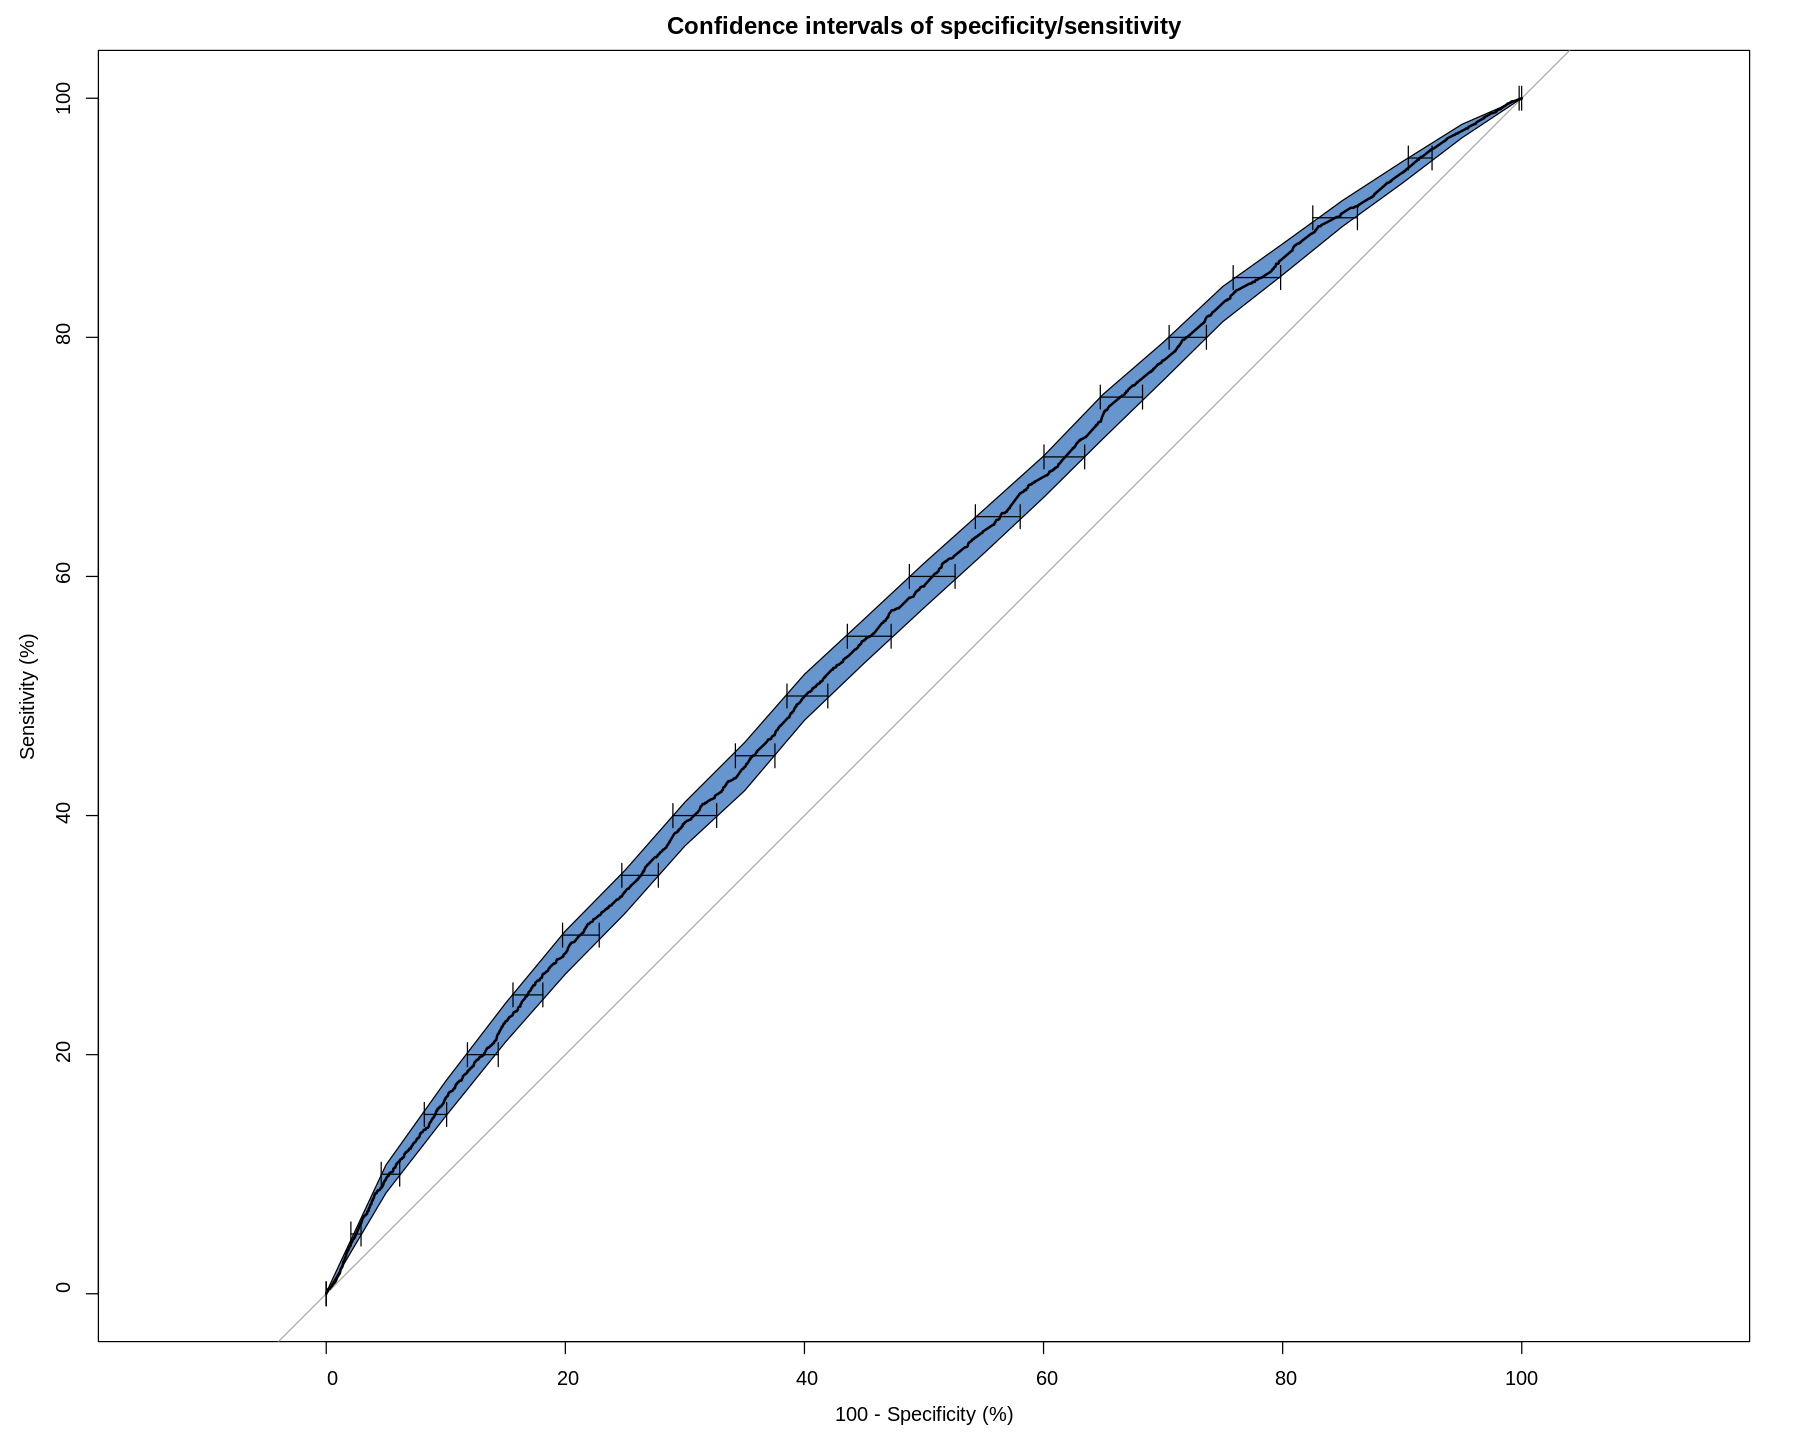

In [15]:
rocobj <- plot.roc(combined_test$donation_2020_binary, lasso_predictions,
                   main = "Confidence intervals of specificity/sensitivity", 
                   percent = TRUE,
                   ci = TRUE, 
                   of = "se",                                # ci of sensitivity
                   specificities = seq(0, 100, 5),           # on a select set of specificities
                   ci.type="shape",
                    legacy.axes=TRUE,
 
                   ci.col="#1c61b6AA")      # plot the CI as a blue shape
plot(ci.sp(rocobj, 
           sensitivities = seq(0, 100, 5)), # ci of specificity
     type = "bars")                         # print this one as bars

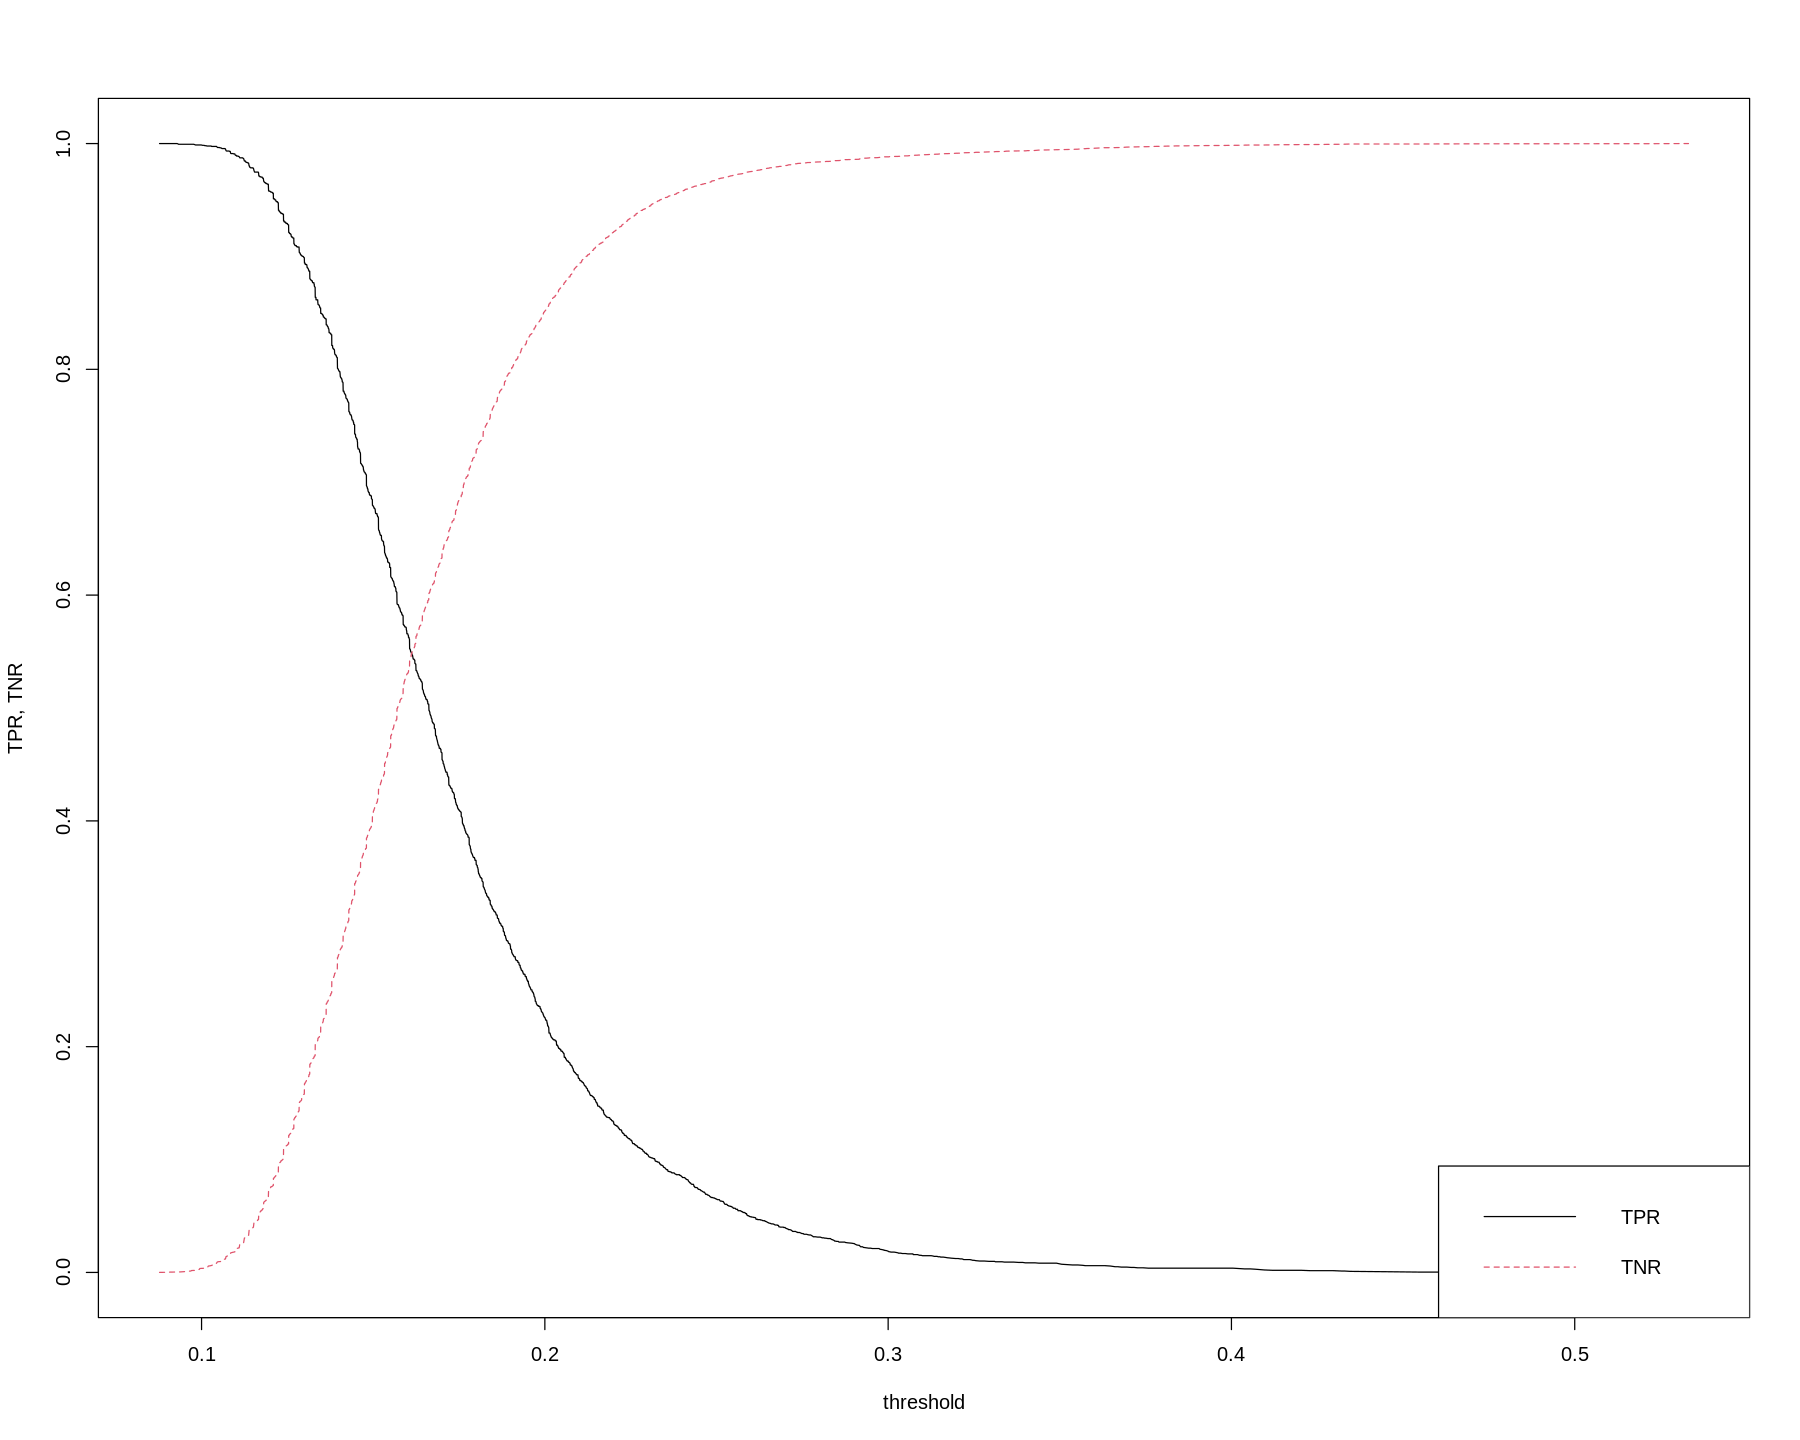

In [16]:
# look at TPR and TNR distribution over threshold
matplot(data.frame(roc_fit$sensitivities, roc_fit$specificities), x = roc_fit$thresholds, type='l', xlab = 'threshold', ylab='TPR, TNR')
legend('bottomright', legend=c('TPR', 'TNR'), lty=1:2, col=1:2)

The above ROC curve informs how well the model is able to distinguish between classes. The curve shows the proportion of classified true positives (y-axis) and false positives (x-axis). 


The curve is generated by varying the probability threshold for classification. This curve can be used to select an optimal threshold. 

First, as indicated by the AUC, this classifier is not very discriminative - implying a lower threshold to maximize the True Positive Rate.

Second, you will need to choose a threshold appropriate for your goal. 
The second plot enables us to weigh the varying distributions for our TPR and FPR. The tradeoff with this is that you will need to decrease one of the TPR (true positive rate, or sensitivity), or TNR (true negative rate, or specificity) in order to increase the other. So, depending on your problem, you might e.g. happen to need a low false positive rate (FPR = 1 - TNR). I would imagine a political campaign would want a low false positive rate which in turn will require us to have a high TNR.

Here we would possibily very low FPR we may  want to choose a lower threshold instead - 0.166. Below we corroborate our manual calculation

In [17]:
# Sanity check - aligns with my computed sensitivity
coords(roc_fit, "best", ret=c("threshold", "specificity", "1 - npv"))

threshold,specificity
<dbl>,<dbl>
0.1661863,0.5966046


In [18]:
label <- as.factor(ifelse(lasso_predictions > classifier_threshold, '1', '0'))
confusionMatrix(label, reference = as.factor(combined_test$donation_2020_binary), positive = '1')

Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0 16012  2646
         1  1777   518
                                          
               Accuracy : 0.7889          
                 95% CI : (0.7833, 0.7944)
    No Information Rate : 0.849           
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.0719          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.16372         
            Specificity : 0.90011         
         Pos Pred Value : 0.22571         
         Neg Pred Value : 0.85818         
             Prevalence : 0.15100         
         Detection Rate : 0.02472         
   Detection Prevalence : 0.10953         
      Balanced Accuracy : 0.53191         
                                          
       'Positive' Class : 1               
                  

Using an out-of-sample testing set, and a threshold of 0.166, the confusion matrix shown above shows that the second logit model is able to correctly classify 78.8 percent of cases (i.e., 22.1 percent testing error).
This is actually not an improvement on the no information rate, which is 0.8489. 
Moreover, the model only correctly identifies positive classes (i.e., 2020 donors) on 16.37 percent of time. 

The model correctly identifies negative classes (i.e., non - 2020 donors) at 90 percent.